In [1]:
!pip install -q wordcloud
import wordcloud

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import unicodedata
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, LatentDirichletAllocation, PCA
from sklearn import metrics
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS  # a longer list of stopwords than nltk

pd.set_option("display.precision", 4)
np.set_printoptions(precision=4)

In [5]:
from sklearn.datasets import fetch_20newsgroups
CATEGORIES = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

IS_TRAIN_SET = False  # get the test set so that we can compare performance to the one documented on the above scikit web page

if IS_TRAIN_SET:
  news_docs = fetch_20newsgroups(subset='train', categories=CATEGORIES, shuffle=True, random_state=42)
else:
  news_docs = fetch_20newsgroups(subset='test', categories=CATEGORIES, shuffle=True, random_state=42)

TARGET_NAMES = news_docs.target_names
print("TARGET_NAMES:", TARGET_NAMES)
print("len(news_docs.data):", len(news_docs.data))

print(type(news_docs))
data_samples = news_docs.data
data_classes = news_docs.target
print("data_classes:", data_classes)

n_topic_clusters = np.unique(data_classes).shape[0]
print("n_topic_clusters:", n_topic_clusters)

print("Class distribution:")
print(pd.Series(data_classes).value_counts())

TARGET_NAMES: ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']
len(news_docs.data): 1502
<class 'sklearn.utils.Bunch'>
data_classes: [2 2 2 ... 2 2 1]
n_topic_clusters: 4
Class distribution:
3    398
2    396
1    389
0    319
dtype: int64


In [6]:
#@title
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

# Get stopwords, stemmer and lemmatizer
stemmer = nltk.stem.PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()
general_stopwords = ENGLISH_STOP_WORDS  # note: sklearn has a longer list than nltk.corpus.stopwords.words('english')
domain_stopwords = ['subject', 'organization', 'lines', 'from', 'reply-to', 'distribution', 'keywords', 'article', 'newsreader', 'nntp-posting-host', 'writes', 'x-newsreader', 'summary']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Indukala\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Indukala\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Indukala\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Indukala\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


In [7]:
def remove_accents(data):
    return ''.join(x for x in unicodedata.normalize('NFKD', data) if x in string.ascii_letters or x == " ")
  
def remove_misc(data):
  return data.replace('\n', '')

---
Before removing POS that are not nouns and lemmatization:
df_token_lists.shape: (1502, 1200)
df_token_lists.head(5):
        0              1           2       3      4          5            6        7         8           9           10       11        12       13         14           15        16     17        18       19          20          21          22             23           24        25      26          27        28        29       30         31          32          33     34         35         36        37      38      39           40         41          42       43         44        45           46          47        48      49          50     51         52       53   54     55    56         57         58             59       60          61     62         63       64    65       66        67         68         69    70      71       72      73        74       75         76           77         78              79       80         81   82      83   84    85          86    

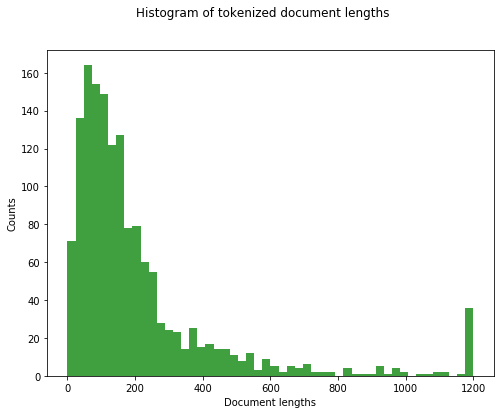

In [8]:
def preprocess_documents(data_samples, data_classes, general_stopwords, domain_stopwords, stemmer, lemmatizer, is_skip_header=True, is_print=False, is_plot=False):
  '''
  Preprocess documents
  
  Parameters:
  data_samples: list of data samples
  data_classes: list of classes
  general_stopwords: list of stopwords used in general
  domain_stopwords: domain specific stopwords that should not appear in the word cloud
  stemmer: the stemmer method
  lemmatizer: the lemmatizer method
  is_skip_header: boolean to skip the header section in each newsgroup
  
  Return:
  df_token_lists: dataframe of tokenized word lists
  df_lem_strings: dataframe of lemmatized word lists
  data_samples_processed: list of the processed lemmatized strings
  data_processed: list of tuples of data_samples_processed and their data classes
  '''

  # POS (Parts Of Speech)
  # For: nouns, adjectives, verbs and adverbs use {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'} 
  DI_POS_TYPES = {'NN':'n'}  # Just the nouns
  POS_TYPES = list(DI_POS_TYPES.keys())

  # Constraints on tokens
  MIN_STR_LEN = 3
  MAX_TOKENS = 1200
  RE_VALID = '[a-zA-Z]'
  PUNCT = ['@', '_', '.']

  # Process all data samples
  li_tokens = []
  li_token_lists = []
  li_lem_strings = []
  len_tokens = []
  
  for i,text in enumerate(data_samples):

      # Tokenize by sentence, then by lowercase word
      tokens = []
      if is_skip_header:
        # Skip most of the first section that represents the header metadata
        for j,sent in enumerate(nltk.sent_tokenize(text)):
          if j == 0:
            li_sents = [s.strip() for s in sent.splitlines()]
            li_sents = [s for s in li_sents if len(s) > 0 and not s.lower().startswith(tuple(domain_stopwords))]
            tokens0 = [token.lower() for sent in li_sents for token in nltk.word_tokenize(sent)]
            tokens = []
            for t in tokens0:
              is_in = False
              for p in PUNCT:
                if p in t:
                  is_in = True
                  break
                  
              if not is_in:    
                tokens.append(t)
              
            continue

          for word in nltk.word_tokenize(sent):
            tokens.append(word.lower())
      else:
        tokens = [token.lower() for sent in nltk.sent_tokenize(text) for token in nltk.word_tokenize(sent)]
      
      # Remove stopwords
      tokens = [x for x in tokens if x not in general_stopwords]
      tokens = [x for x in tokens if x not in domain_stopwords] 
      
      # Limit
      tokens = tokens[:MAX_TOKENS]
      len_tokens.append(len(tokens))

      # Process all tokens per quote
      li_tokens_quote = []
      li_tokens_quote_lem = []
      for token in tokens:
          # Remove email addresses
          if '@' in token:
            continue
          
          # Remove accents
          t = remove_accents(token)

          # Remove misc
          t = remove_misc(t)

          # Remove punctuation
          t = str(t).translate(string.punctuation)
          li_tokens_quote.append(t)

          # Add token that represents "no lemmatization match"
          li_tokens_quote_lem.append('-') # this token will be removed if a lemmatization match is found below

          # Process each token
          if t not in general_stopwords:
              if re.search(RE_VALID, t):
                  if len(t) >= MIN_STR_LEN:
                      # Note that the POS (Part Of Speech) is necessary as input to the lemmatizer 
                      # (otherwise it assumes the word is a noun)
                      pos = nltk.pos_tag([t])[0][1][:2]
                      pos2 = 'n'  # set default to noun
                      if pos in DI_POS_TYPES:
                        pos2 = DI_POS_TYPES[pos]

                      stem = stemmer.stem(t)
                      lem = lemmatizer.lemmatize(t, pos=pos2)  # lemmatize with the correct POS

                      if pos in POS_TYPES:
                          li_tokens.append((t, stem, lem, pos))

                          # Remove the '-' token and append the lemmatization match
                          li_tokens_quote_lem = li_tokens_quote_lem[:-1] 
                          li_tokens_quote_lem.append(lem)

      # Build list of token lists from lemmatized tokens
      li_token_lists.append(li_tokens_quote)

      # Build list of strings from lemmatized tokens
      str_li_tokens_quote_lem = ' '.join(li_tokens_quote_lem)
      li_lem_strings.append(str_li_tokens_quote_lem)

  # Build resulting dataframes from lists
  df_token_lists = pd.DataFrame(li_token_lists)

  # Replace None with empty string
  for c in df_token_lists:
      if str(df_token_lists[c].dtype) in ('object', 'string_', 'unicode_'):
          df_token_lists[c].fillna(value='', inplace=True)

  df_lem_strings = pd.DataFrame(li_lem_strings, columns=['lem string'])

  # Build a dataset that corresponds the processed strings to the class labels
  data_samples_processed = [x.replace('-','') for x in li_lem_strings]
  data_processed = list(zip(data_classes, data_samples_processed))
  
  if is_print:
    print("---")
    print("Before removing POS that are not nouns and lemmatization:")
    print("df_token_lists.shape:", df_token_lists.shape)
    print("df_token_lists.head(5):")
    print(df_token_lists.head(5).to_string())
    
    print("---")
    print("After removing POS that are not nouns and lemmatization:")
    print("df_lem_strings.head():")
    print(df_lem_strings.head().to_string())
    
    print("---")
    for i,v in enumerate(data_processed[:5]):
      print(i,v)

  # Plot histogram of tokenized document lengths
  if is_plot:
    fig = plt.figure(figsize=(8,6))
    plt.suptitle("Histogram of tokenized document lengths")
    plt.xlabel("Document lengths")
    plt.ylabel("Counts")
    n, bins, patches = plt.hist(len_tokens, bins=50, density=False, facecolor='g', alpha=0.75)
    plt.show()
  
  return df_token_lists, df_lem_strings, data_samples_processed, data_processed

# Preprocess documents
df_token_lists, df_lem_strings, data_samples_processed, data_processed = \
  preprocess_documents(data_samples, data_classes, general_stopwords, domain_stopwords, stemmer, lemmatizer, is_skip_header=True, is_print=True, is_plot=True)


In [9]:
 # Build tf-idf vectorizer and related variables from the input documents
# to support both unigrams and bigrams use: ngram_range=(1,2)
def build_vectorizer(documents, ngram_range=(1,1), max_df=1.0, min_df=1, stop_words=None, max_features=None):   # default CountVectorizer parameter values
    '''
    (i) Build count_vectorizer from the documents and fit the documents  
    (ii) Build TF (Term Frequency) from the documents, this is a sparse version of the bag-of-words  
    (iii) Build bag-of-words in two steps: fit, transform  
    (iv) Get feature names and build dataframe version of the bag-of-words  
    (v) Use TfidfTransformer to transform bag_of_words into TF-IDF matrix (Term Frequency - Inverse Document Frequency)  
    (vi) Find most popular words and highest weights  
    (vii) Build word weights as a list and sort them  
    (viii) Calculate cosine similarity of all documents with themselves  
    (ix) Calculate distance matrix of documents  
    
    Note:
    The TF_IDF matrix can be built directly with 'TfidfVectorizer' instead of using 'CountVectorizer' followed by 'TfidfTransformer'
    
    Return:
    cvec: CountVectorizer
    tf: Term Frequencies
    tfidf: TF-IDF matrix 
    feature_names: Feature names in TF-IDF
    df_bag_of_words: Bag of words from the sparse Term Frequencies
    df_weights: Most popular words, word counts and highest weights
    cos_sim: Cosine similarity of all documents with themselves
    samp_dist: Distance matrix of documents
    '''
    
    # Build CountVectorizer from the documents and fit the documents
    count_vectorizer = CountVectorizer(ngram_range=ngram_range, max_df=max_df, min_df=min_df, stop_words=stop_words, max_features=max_features)
    
    # Build TF (Term Frequencies) from the documents, this is a sparse version of the bag-of-words
    tf = count_vectorizer.fit_transform(documents)  # note that the LDA transform needs this for its clustering model (explained below)

    # Build bag-of-words in two steps: fit, transform
    cvec = count_vectorizer.fit(documents)
    bag_of_words = cvec.transform(documents)
    
    # Get feature names and build dataframe version of the bag-of-words
    feature_names = cvec.get_feature_names()
    df_bag_of_words = pd.DataFrame(bag_of_words.todense(), columns=feature_names)
    
    # Use TfidfTransformer to transform bag_of_words into TF-IDF matrix (Term Frequency - Inverse Document Frequency)
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(bag_of_words)

    # Find most popular words, word counts and highest weights
    word_cnts = np.asarray(bag_of_words.sum(axis=0)).ravel().tolist()  # for each word in column, sum all row counts
    df_cnts = pd.DataFrame({'word': feature_names, 'count': word_cnts})
    df_cnts = df_cnts.sort_values('count', ascending=False)

    # Build word weights as a list and sort them (the dataframe below also contains the counts)
    weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
    df_weights = pd.DataFrame({'word': feature_names, 'weight': weights})
    df_weights = df_weights.sort_values('weight', ascending=False)

    df_weights = df_weights.merge(df_cnts, on='word', how='left')
    df_weights = df_weights[['word', 'count', 'weight']]

    # Calc cosine similarity of all documents with themselves
    cos_sim = metrics.pairwise.cosine_similarity(tfidf, tfidf)

    # Calc distance matrix of documents
    samp_dist = 1 - cos_sim

    return cvec, tf, tfidf, feature_names, df_bag_of_words, df_weights, cos_sim, samp_dist
  
# Build TF-IDF matrices
li_lem_strings = df_lem_strings['lem string'].values.tolist()
cvec, tf, tfidf, feature_names, df_bag_of_words, df_weights, cos_sim, samp_dist = build_vectorizer(li_lem_strings)

Word cloud based on all categories:
         word  count  weight
0         god   1287  0.0275
1      people    805  0.0164
2       think    709  0.0160
3   christian    552  0.0146
4        time    655  0.0139
5  university    399  0.0133
6        book    434  0.0129
7       image    561  0.0128
8      thanks    221  0.0121
9      church    460  0.0121


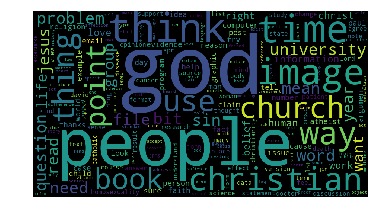

In [10]:
def word_cloud(df_weights, n_top_words=10, is_print=True, is_plot=True):
  '''
  Build a word cloud
  '''
  s_word_freq = pd.Series(df_weights['count'])
  s_word_freq.index = df_weights['word']
  di_word_freq = s_word_freq.to_dict()
  cloud = wordcloud.WordCloud(width=900, height=500).generate_from_frequencies(di_word_freq)
 
  if is_print:
    print(df_weights.iloc[:n_top_words,:])
  
  if is_plot:
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()
  
  return cloud
  
# Build word cloud
print("Word cloud based on all categories:")
cloud_all = word_cloud(df_weights, is_print=True)

In [11]:
def word_cloud_per_class(i_class, data_samples, general_stopwords, domain_stopwords, stemmer, lemmatizer, is_skip_header=True):
  print("Category:", TARGET_NAMES[i_class])
  print("----------------------------------")
  data_samples_group = [x for i,x in enumerate(data_samples) if data_classes[i] == i_class]
  data_classes_group = [i_class] * len(data_samples_group)
  
  # Preprocess documents
  df_token_lists_per_class, df_lem_strings_per_class, data_samples_processed_per_class, data_processed_per_class = \
    preprocess_documents(data_samples_group, data_classes_group, general_stopwords, domain_stopwords, stemmer, lemmatizer, is_skip_header)
  
  # Build TF-IDF matrices
  li_lem_strings = df_lem_strings_per_class['lem string'].values.tolist()
  cvec, tf, tfidf, feature_names, df_bag_of_words, df_weights, cos_sim, samp_dist = \
    build_vectorizer(li_lem_strings)

  # Build word cloud
  cloud = word_cloud(df_weights)
  return cloud

Category: alt.atheism
----------------------------------
       word  count  weight
0       god    331  0.0373
1   atheist    178  0.0277
2  religion    198  0.0269
3     think    236  0.0263
4    people    234  0.0230
5    belief    193  0.0216
6      book    153  0.0205
7      time    180  0.0196
8     claim    140  0.0172
9      mean    137  0.0172


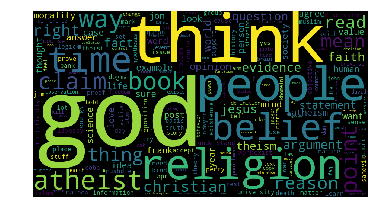

In [12]:
i_class = 0
word_cloud_per_class(i_class, data_samples, general_stopwords, domain_stopwords, stemmer, lemmatizer, is_skip_header=True)

Category: comp.graphics
----------------------------------
         word  count  weight
0       image    505  0.0354
1         bit    323  0.0327
2        file    303  0.0314
3      thanks    111  0.0251
4     graphic    226  0.0247
5      format    168  0.0237
6     program    189  0.0234
7    computer    206  0.0222
8  university    154  0.0211
9       email    129  0.0177


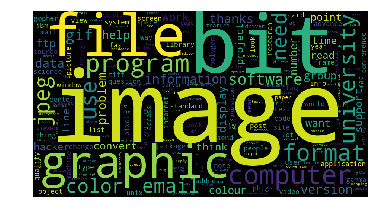

In [13]:
i_class = 1
word_cloud_per_class(i_class, data_samples, general_stopwords, domain_stopwords, stemmer, lemmatizer, is_skip_header=True)

Category: sci.med
----------------------------------
          word  count  weight
0       doctor    169  0.0192
1         drug    155  0.0178
2       people    161  0.0164
3       effect    136  0.0158
4      patient    193  0.0152
5  information    106  0.0152
6         time    155  0.0150
7   university    101  0.0149
8          use    147  0.0143
9        think    125  0.0143


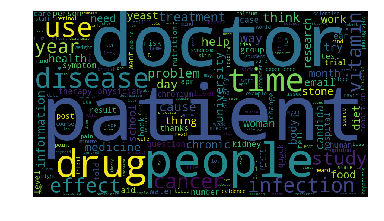

In [14]:
i_class = 2
word_cloud_per_class(i_class, data_samples, general_stopwords, domain_stopwords, stemmer, lemmatizer, is_skip_header=True)

Category: soc.religion.christian
----------------------------------
        word  count  weight
0        god    922  0.0539
1  christian    436  0.0333
2        sin    375  0.0329
3     church    401  0.0315
4     people    351  0.0255
5       mary    159  0.0254
6      jesus    254  0.0240
7     christ    272  0.0229
8      think    275  0.0222
9       book    175  0.0221


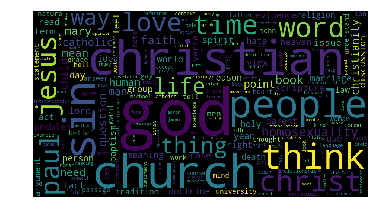

In [15]:
i_class = 3
word_cloud_per_class(i_class, data_samples, general_stopwords, domain_stopwords, stemmer, lemmatizer, is_skip_header=True)

In [17]:
# Note that for this simplistic dataset we don't really need to iterate
# and usually we don't know the number of topic clusters in advance!
km_model = KMeans(n_clusters=n_topic_clusters, max_iter=10, n_init=2, random_state=0)

# K-means (transform dimensions from number of features in input matrix to n_clusters)
km_model.fit(X_pca)
df_centers = pd.DataFrame(km_model.cluster_centers_, columns=['x', 'y'])

print("df_centers:")
print(df_centers)

df_centers:
        x       y
0  0.2301  0.0769
1 -0.0494 -0.0335
2 -0.1414  0.1727
3  0.0655 -0.0186


In [18]:
# K-means model labels and actual document labels
df_documents = pd.DataFrame(data_processed, columns=['Label', 'Document'])
print(df_documents.head())

actual_labels = df_documents['Label'].tolist()
km_model_labels = km_model.labels_.tolist()

   Label                                           Document
0      2  recall bout kidney stone   medication relieve ...
1      2    banschbach    class  question   use patient ...
2      2    chorley       gtclark    clark     msnyder  ...
3      0     bil  conner       atheist  argue parody   r...
4      3   juxtaposition ancient text   sacramentis     ...


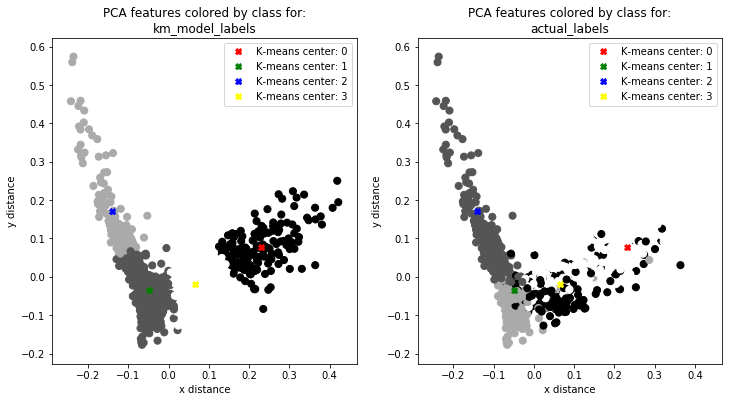

In [19]:
def scatter_plot_with_labels(i_plot, df_centers, labels, title):
  ax = plt.subplot(1, 2, i_plot)
  ax.set_title('PCA features colored by class for:\n' + title)
  ax.set_xlabel('x distance')
  ax.set_ylabel('y distance')
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=50, cmap='gray')

  colors = ['red', 'green', 'blue', 'yellow']
  for i,color in enumerate(df_centers.index.tolist()):
    plt.plot(df_centers['x'][i], df_centers['y'][i], 'X', label='K-means center: %d' % i, color=colors[i])

  plt.legend()

plt.figure(figsize=(12,6))
scatter_plot_with_labels(1, df_centers, km_model_labels, "km_model_labels")
scatter_plot_with_labels(2, df_centers, actual_labels, "actual_labels")
plt.show()

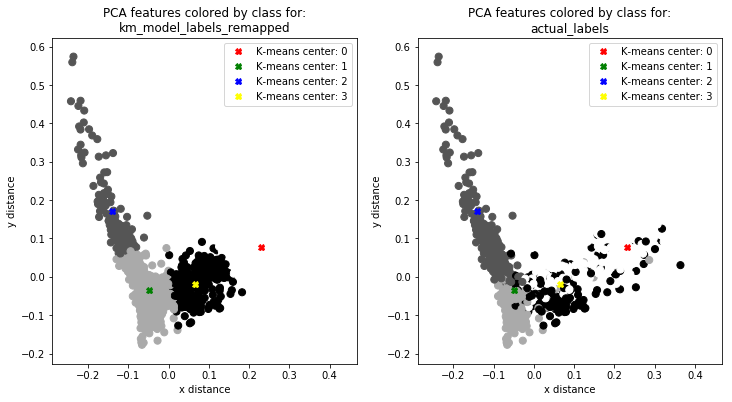

In [20]:
# di_actual_to_kmeans = {0:0, 1:1, 2:2, 3:3}  # no color remapping
di_actual_to_kmeans = {0:3, 1:2, 2:1, 3:0}
km_model_labels_remapped = [di_actual_to_kmeans[x] for x in km_model_labels]

plt.figure(figsize=(12,6))
scatter_plot_with_labels(1, df_centers, km_model_labels_remapped, "km_model_labels_remapped")
scatter_plot_with_labels(2, df_centers, actual_labels, "actual_labels")
plt.show()